# Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\ahmet\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).

  from pandas.core import (


# Reading Data and Performing EDA

In [2]:
# Data taken from https://worldpopulationreview.com/country-rankings/electricity-consumption-by-country on 12.06.2024
df=pd.read_csv("electricity-consumption-by-country-2024.csv")

In [3]:
df.tail()
# The numerical data given here is in billion kWh

,country,ElectricityConsumption2021,ElectricityConsumption2020,ElectricityConsumption2019
203,Nauru,0.04,0.03,0.03
204,Saint Pierre and Miquelon,0.05,0.05,0.05
205,Montserrat,0.01,0.01,0.02
206,Falkland Islands,0.02,0.02,0.02
207,Total,25336.00,23958.94,23914.91


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 208 entries, 0 to 207

Data columns (total 4 columns):

 #   Column                      Non-Null Count  Dtype  

---  ------                      --------------  -----  

 0   country                     208 non-null    object 

 1   ElectricityConsumption2021  208 non-null    float64

 2   ElectricityConsumption2020  208 non-null    float64

 3   ElectricityConsumption2019  208 non-null    float64

dtypes: float64(3), object(1)

memory usage: 6.6+ KB


We have electricity consumption values for 207 countries over 3 years. Let's plot these on a world map!

In [5]:
df.describe()

,ElectricityConsumption2021,ElectricityConsumption2020,ElectricityConsumption2019
count,208.000000,208.000000,208.000000
mean,243.615385,230.374423,229.951058
std,1855.825479,1751.130291,1743.497969
min,0.010000,0.010000,0.020000
25%,1.025000,1.150000,1.225000
50%,9.275000,9.150000,9.000000
75%,51.855000,47.865000,50.452500
max,25336.000000,23958.940000,23914.910000


# Data Visualization

Let's create pie charts to see which country consumes the most electricity in the world.

In [6]:
df["Percentile_2021"]=df["ElectricityConsumption2021"] / df["ElectricityConsumption2021"].iloc[-1] * 100
df["Percentile_2020"]=df["ElectricityConsumption2020"] / df["ElectricityConsumption2020"].iloc[-1] * 100
df["Percentile_2019"]=df["ElectricityConsumption2019"] / df["ElectricityConsumption2019"].iloc[-1] * 100

The 'Total' column is not useful anymore, so I will drop it.

In [7]:
df.drop(df.loc[df["country"]=="Total"].index,inplace=True)

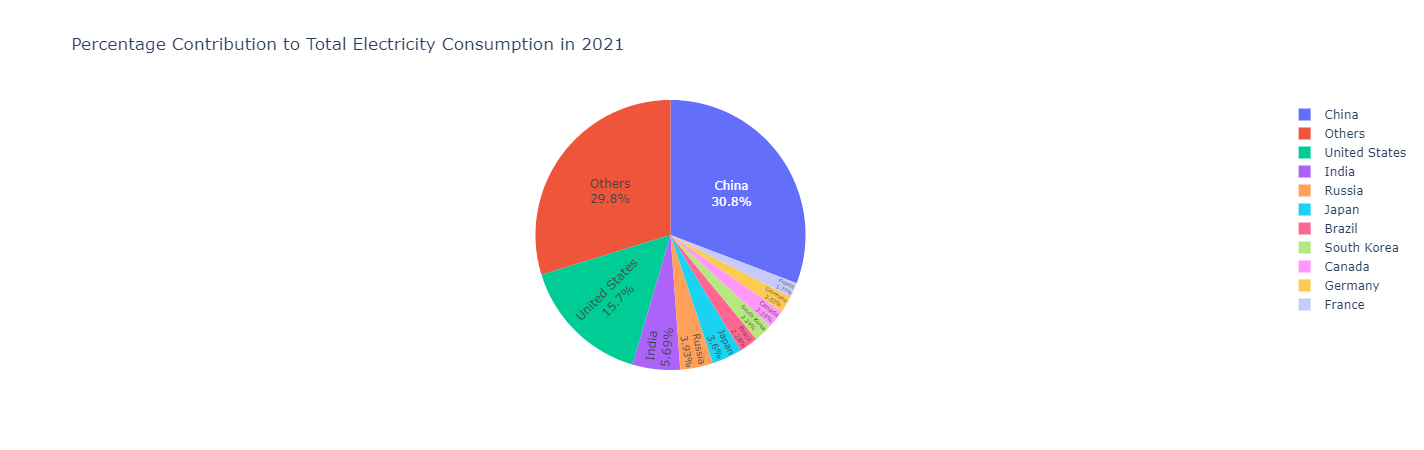

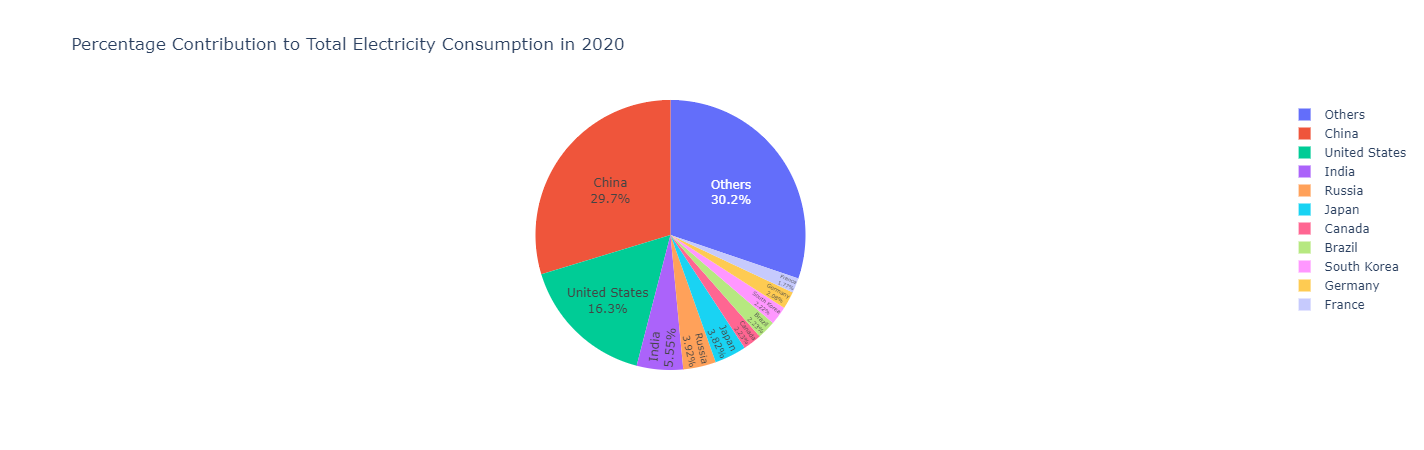

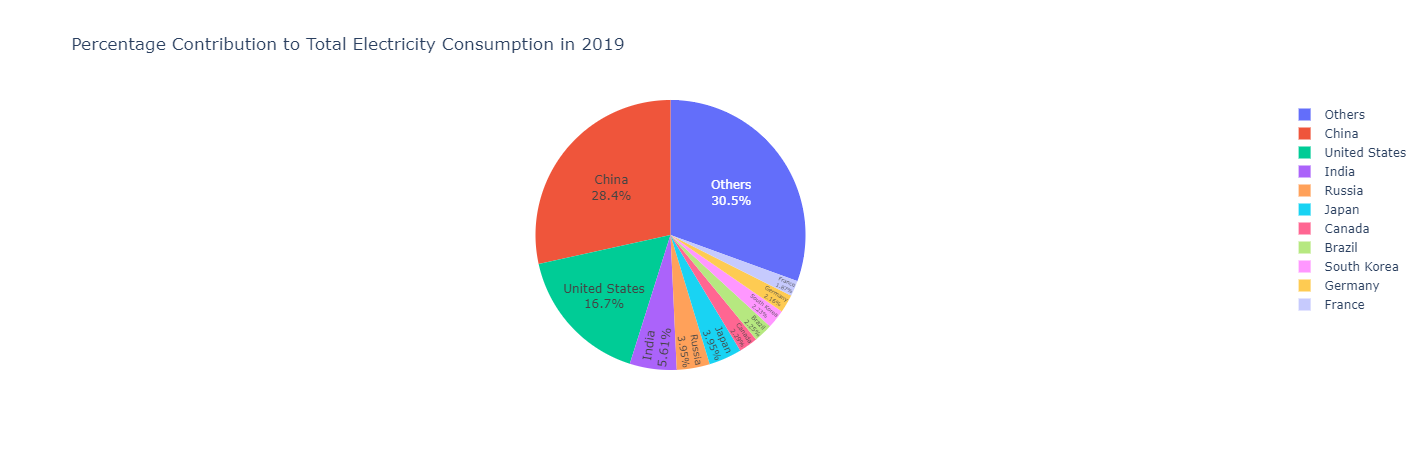

In [8]:
threshold=1.5
for col in df.columns[-3:]:# Create a pie chart
    
    df_temp=df.copy()
    df_temp.loc[df_temp[f"Percentile_{col[-4:]}"] < threshold, "country"] = "Others"
    df_grouped = df_temp.groupby("country", as_index=False).agg({
    f"ElectricityConsumption{col[-4:]}": "sum",
    f"Percentile_{col[-4:]}": "sum"
    })


    fig = px.pie(
        df_grouped,
        names="country",
        values=f"{col}",
        title=f"Percentage Contribution to Total Electricity Consumption in {col[-4:]}"
    )

    # Update the layout to improve readability
    fig.update_traces(textposition="inside", textinfo="percent+label")

    # Show the plot
    fig.show()

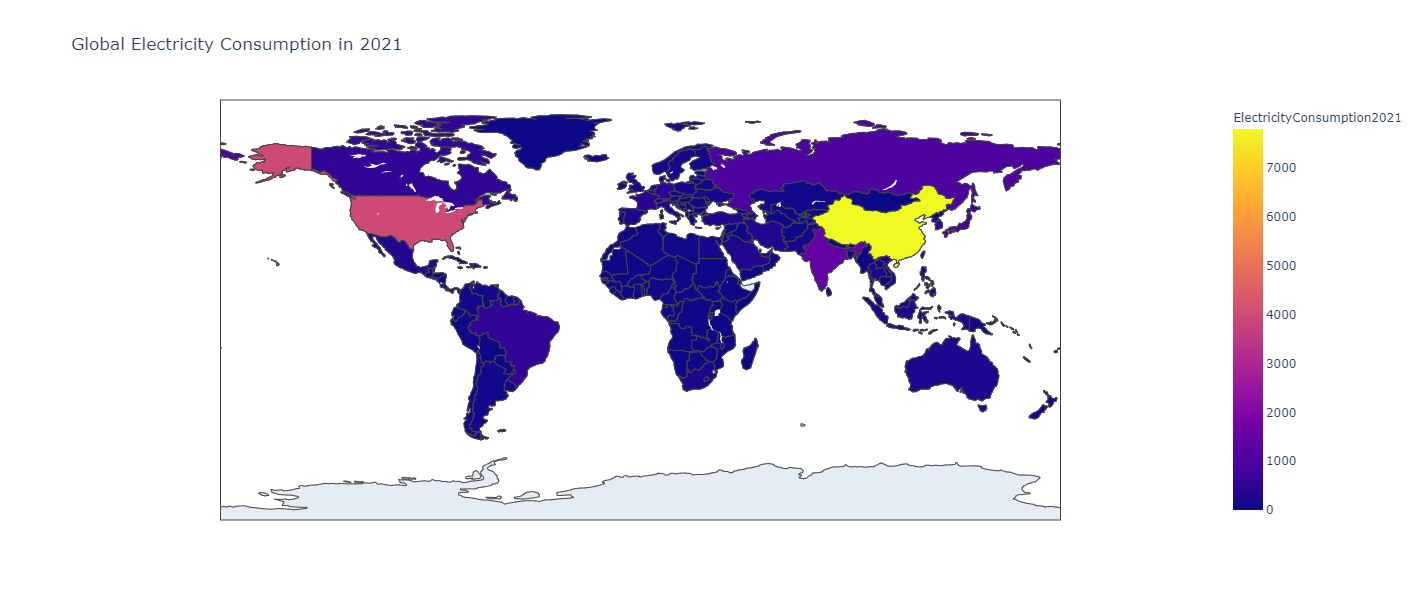

In [9]:
fig = px.choropleth(
    df,
    locations="country",
    locationmode="country names",
    color="ElectricityConsumption2021",
    hover_name="country",
    color_continuous_scale="Plasma",
    title="Global Electricity Consumption in 2021"
)


# Update layout for larger size
fig.update_layout(
    width=1000,  # Set the width
    height=600   # Set the height
)

fig.show()

Since China has the largest electricity consumption in the world and its values are very high compared to others, we cannot understand the other countries from this figure. So, I will take the log of these values and color them based on the logarithmic values.

In [10]:
# Log-transformation the Electricity Consumption 2021
df["LogElectricityConsumption2021"] = np.log(df["ElectricityConsumption2021"])

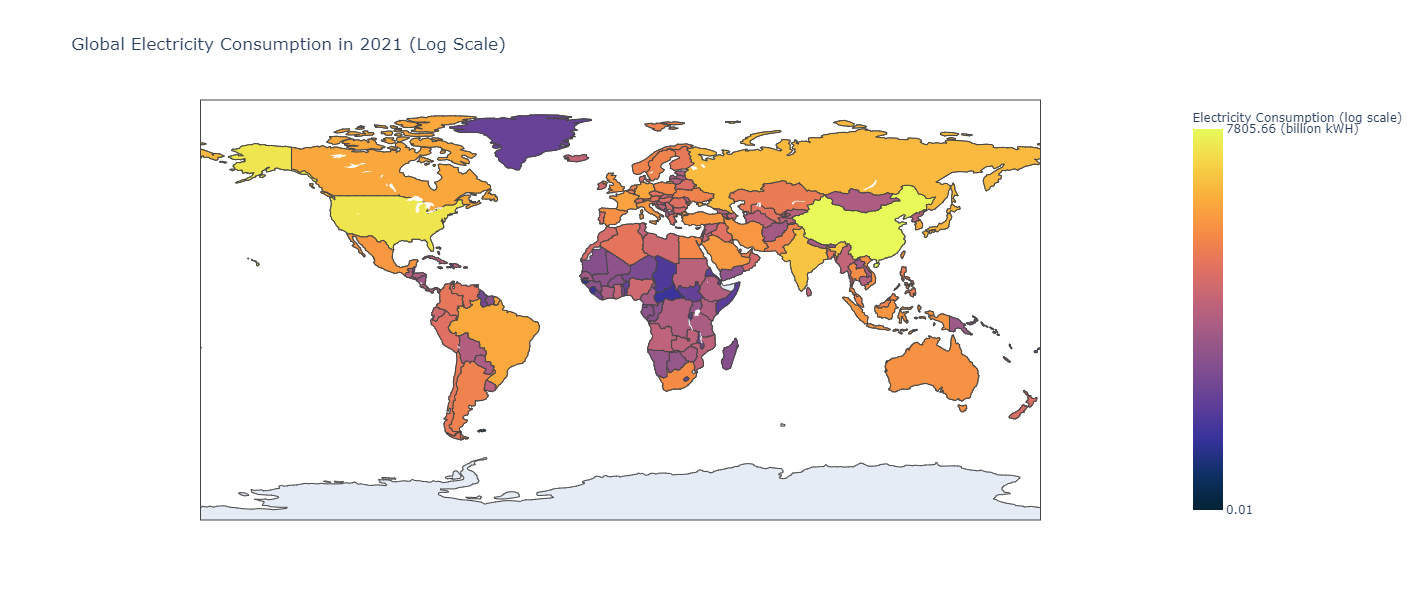

In [11]:

# Create a larger choropleth map with a different colormap
fig = px.choropleth(
    df,
    locations="country",
    locationmode="country names",
    color="LogElectricityConsumption2021",  # Use log-transformed data for color
    hover_name="country",
    hover_data={"ElectricityConsumption2021": True, "LogElectricityConsumption2021": False}, # Showing real values
    color_continuous_scale="thermal",  
    title="Global Electricity Consumption in 2021 (Log Scale)"
)

# Update layout for larger size
fig.update_layout(
    width=1000,  # Set the width
    height=600,   # Set the height
    coloraxis_colorbar=dict(
        title="Electricity Consumption (log scale)",
        tickvals=[df["LogElectricityConsumption2021"].min(), 
                  df["LogElectricityConsumption2021"].max()],

        ticktext=[f'{df["ElectricityConsumption2021"].min()}', f'{df["ElectricityConsumption2021"].max()} (billion kWH)']
    )
)

# Show the plot
fig.show()

The chart is now more readable. Let's do this for all the years

In [12]:
df.columns[1:4]

Index(['ElectricityConsumption2021', 'ElectricityConsumption2020',
       'ElectricityConsumption2019'],
      dtype='object')

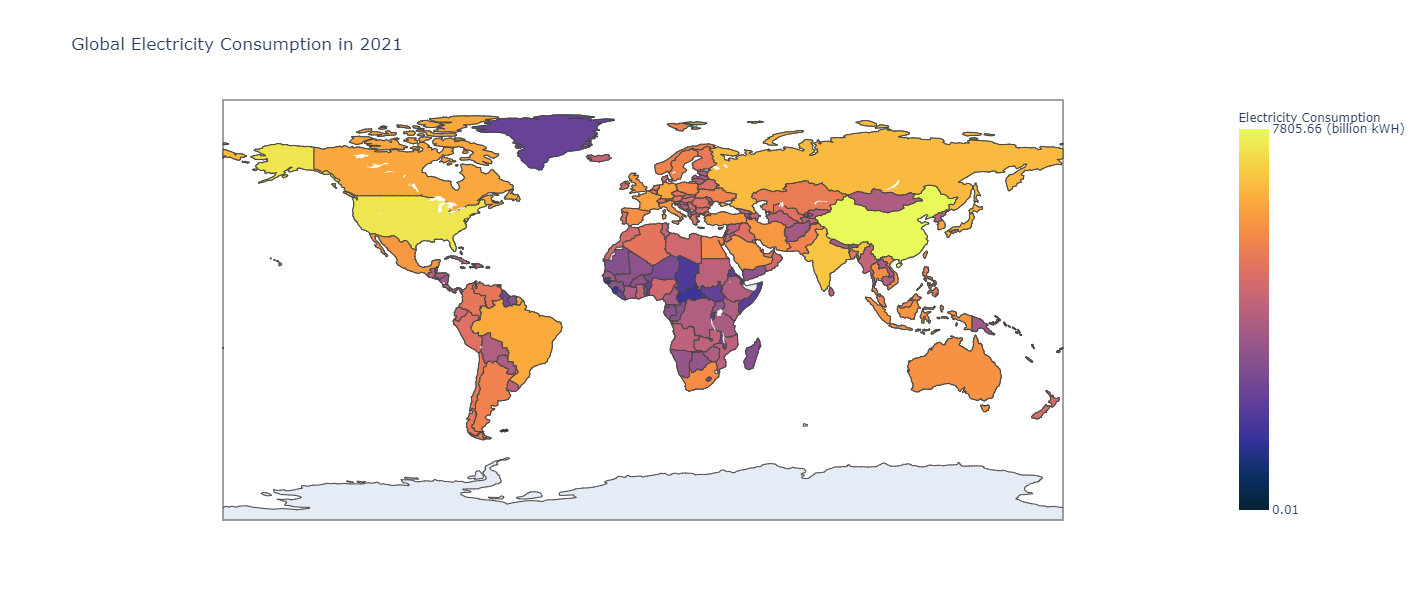

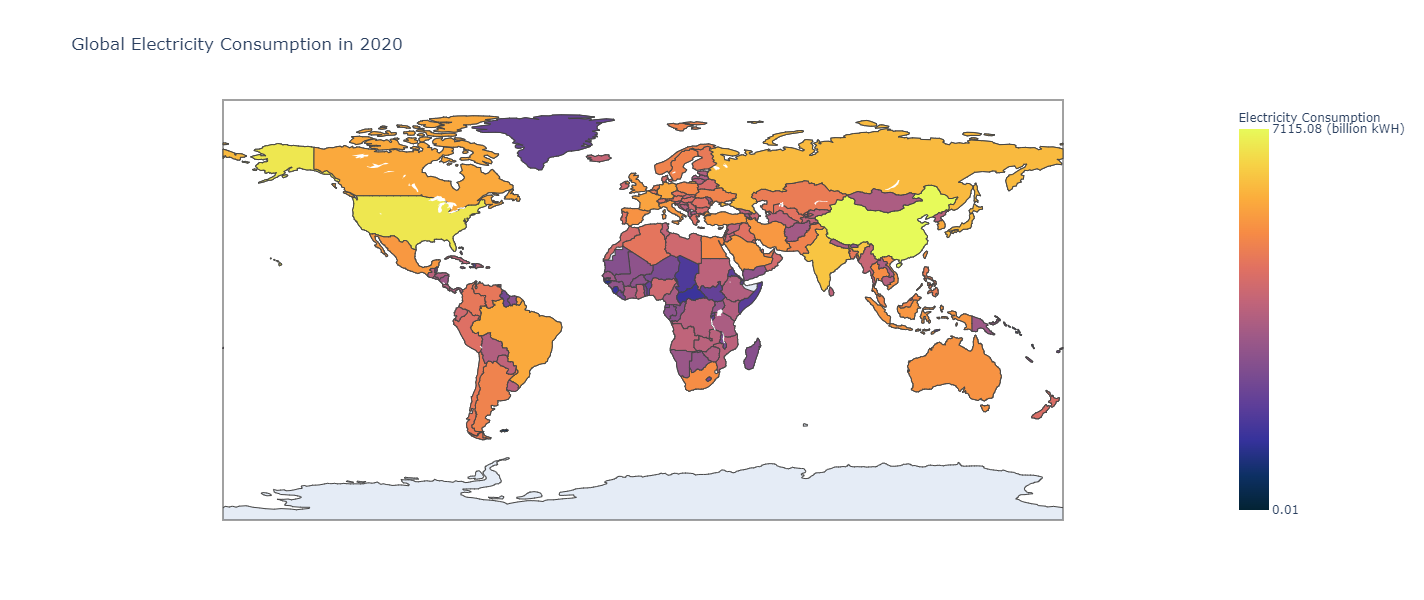

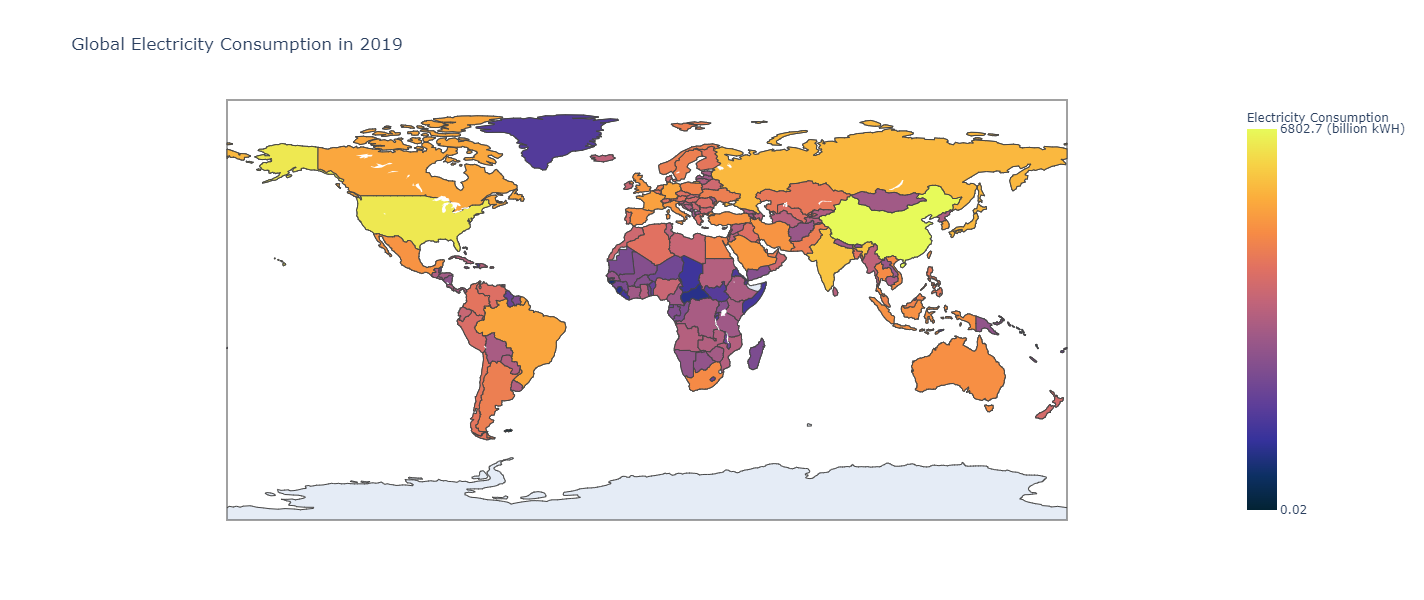

In [13]:
for col in df.columns[1:4]:
    df[f"Log{col}"] = np.log(df[f"{col}"])
    
    # Create a larger choropleth map with a different colormap
    fig = px.choropleth(
        df,
        locations="country",
        locationmode="country names",
        color=f"Log{col}",  # Use log-transformed data for color
        hover_name="country",
        hover_data={f"{col}": True, f"Log{col}": False}, # showing real values
        color_continuous_scale="thermal",  
        title=f"Global Electricity Consumption in {col[-4:]}"
    )

    # Update layout for larger size
    fig.update_layout(
        width=1000,  # Set the width
        height=600,   # Set the height
        coloraxis_colorbar=dict(
            title="Electricity Consumption",
            tickvals=[df[f"Log{col}"].min(), 
                    df[f"Log{col}"].max()],

            ticktext=[f'{df[f"{col}"].min()}', f'{df[f"{col}"].max()} (billion kWH)']
        )
    )

    # Show the plot
    fig.show()

In [14]:
for col in df.columns[1:4]:
    top_consumers = df.nlargest(1, f"{col}")
    bottom_consumers = df.nsmallest(1, f"{col}")

    print(f"Top Consumer in {col[-4:]}:", str(top_consumers.iloc[0,0]))
    print(f"Bottom Consumer in {col[-4:]}:", str(bottom_consumers.iloc[0,0]))


Top Consumer in 2021: China

Bottom Consumer in 2021: Montserrat

Top Consumer in 2020: China

Bottom Consumer in 2020: Montserrat

Top Consumer in 2019: China

Bottom Consumer in 2019: Montserrat


What about growing rate ?

In [15]:
df["Growth_2019_2020"] = (df["ElectricityConsumption2020"] - df["ElectricityConsumption2019"]) / df["ElectricityConsumption2019"] * 100
df["Growth_2020_2021"] = (df["ElectricityConsumption2021"] - df["ElectricityConsumption2020"]) / df["ElectricityConsumption2020"] * 100
df["Growth_2019_2021"] = (df["ElectricityConsumption2021"] - df["ElectricityConsumption2019"]) / df["ElectricityConsumption2019"] * 100

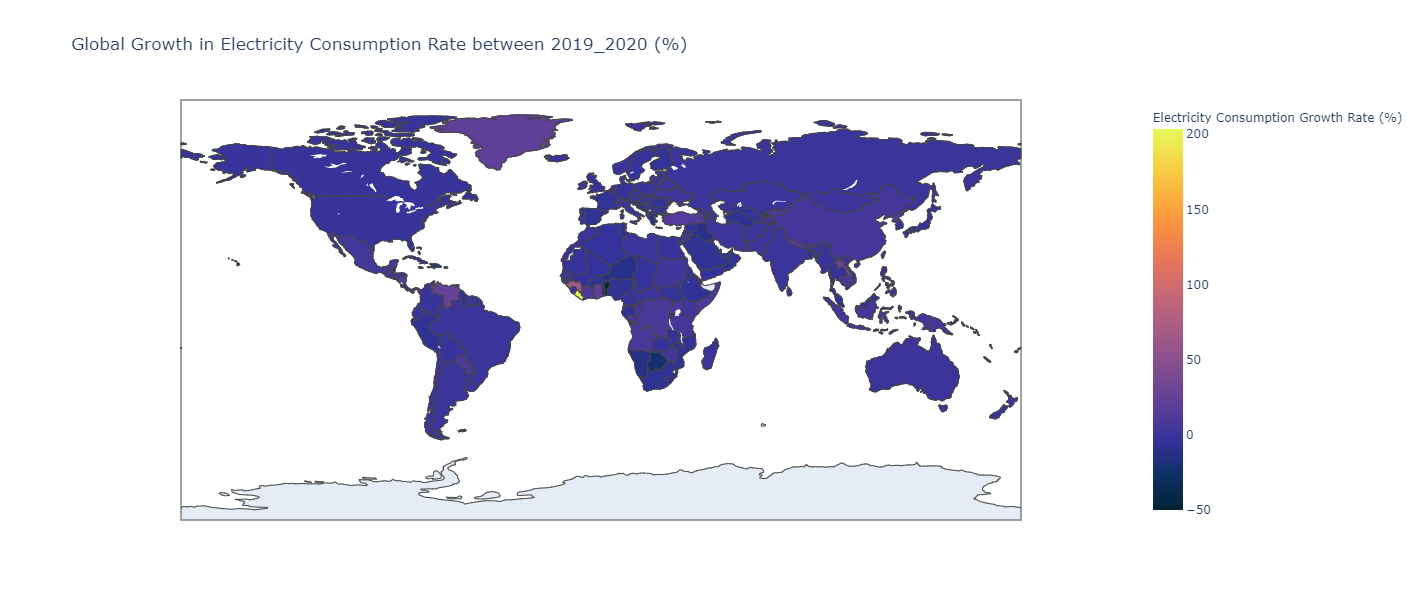

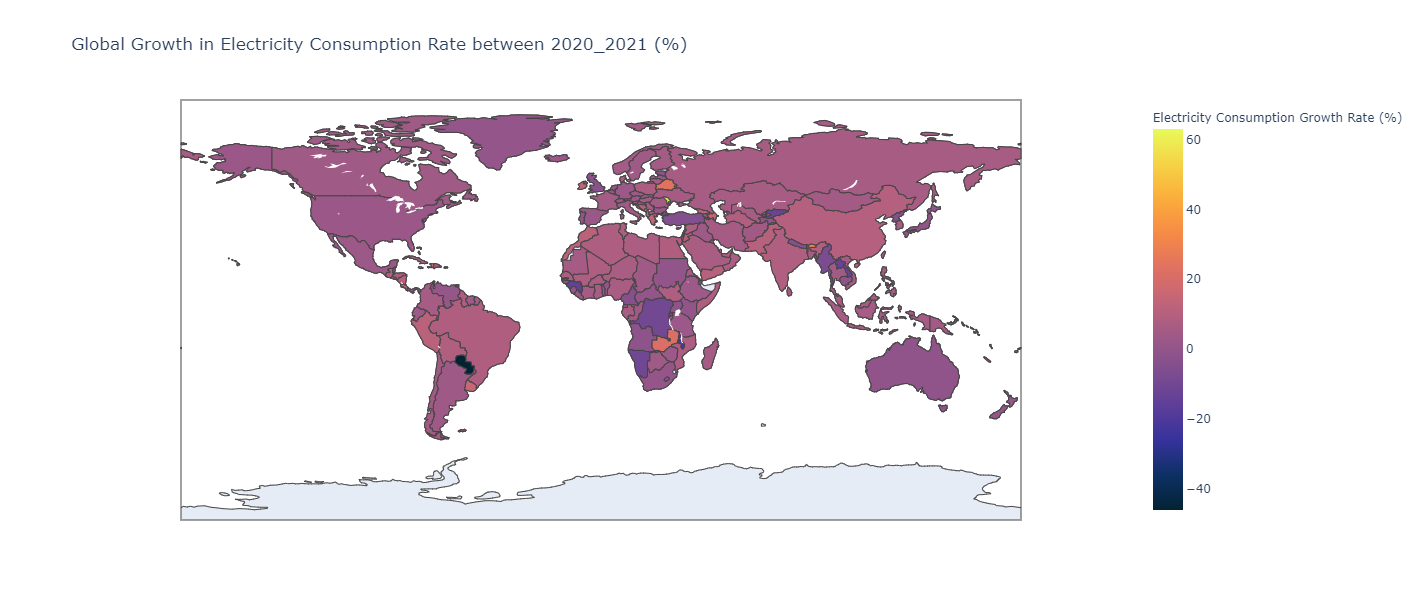

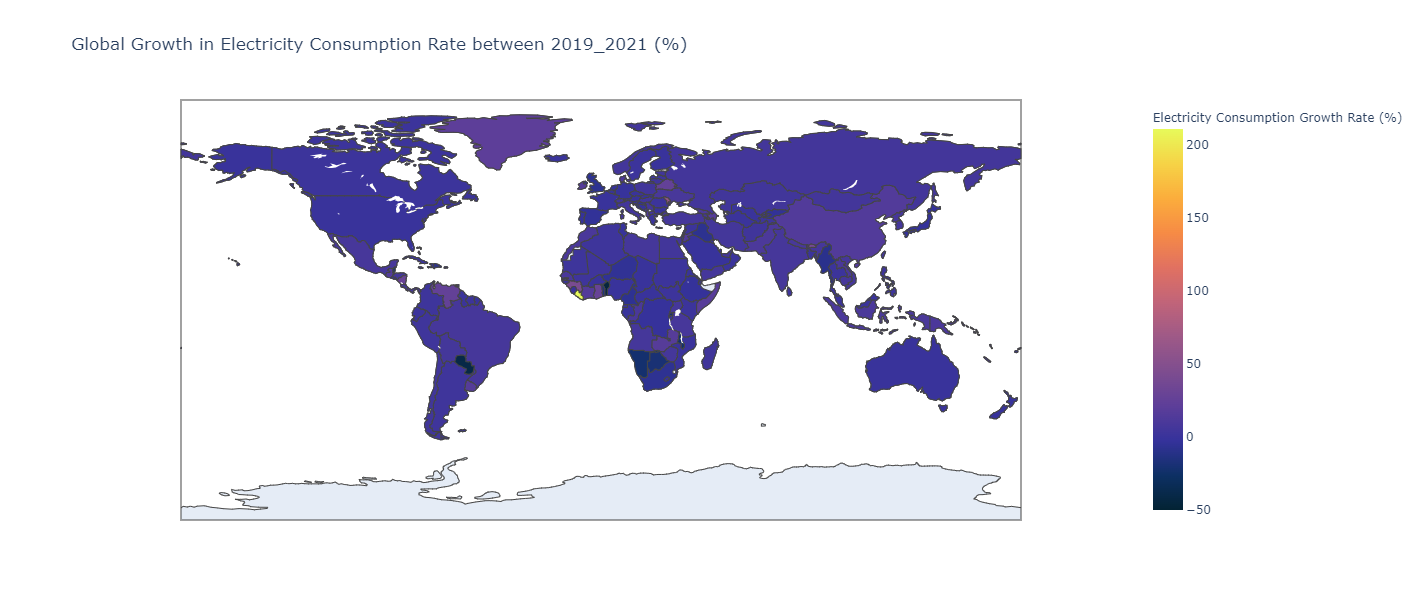

In [16]:
for col in df.columns[-3:]:
    # Create a larger choropleth map with a different colormap
    fig = px.choropleth(
        df,
        locations="country",
        locationmode="country names",
        color=f"{col}",  # Use growth rate fro color
        hover_name="country",
        hover_data={f"{col}": True}, # showing real values
        color_continuous_scale="thermal",  
        title=f"Global Growth in Electricity Consumption Rate between {col[-9:]} (%)"
    )

    # Update layout for larger size
    fig.update_layout(
        width=1000,  # Set the width
        height=600,   # Set the height
        coloraxis_colorbar=dict(
            title="Electricity Consumption Growth Rate (%)",
            )
    )

    # Show the plot
    fig.show()

In [17]:
for col in df.columns[-3:]:
    top_consumers = df.nlargest(1, f"{col}")
    bottom_consumers = df.nsmallest(1, f"{col}")

    print(f"Top Consumer in Growth Rate between {col[-9:]}: {str(top_consumers.iloc[0,0])} with a {round(top_consumers[col].iloc[0],2)}% growth rate")
    print(f"Bottom Consumer in Growth Rate between {col[-9:]}: {str(bottom_consumers.iloc[0,0])} with a {round(bottom_consumers[col].iloc[0],2)}% growth rate")
    print("\n")


Top Consumer in Growth Rate between 2019_2020: Liberia with a 203.57% growth rate

Bottom Consumer in Growth Rate between 2019_2020: Montserrat with a -50.0% growth rate





Top Consumer in Growth Rate between 2020_2021: Moldova with a 63.07% growth rate

Bottom Consumer in Growth Rate between 2020_2021: Paraguay with a -46.22% growth rate





Top Consumer in Growth Rate between 2019_2021: Liberia with a 210.71% growth rate

Bottom Consumer in Growth Rate between 2019_2021: Montserrat with a -50.0% growth rate






# Creating Model

Lets create a Kmeans model fro 4 classes, just for fun

In [18]:
features = ["ElectricityConsumption2021", "ElectricityConsumption2020", "ElectricityConsumption2019"]
# I selected these columns because I think they are important
X = df[features].copy()

In [19]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

c:\Users\ahmet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning:



KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



c:\Users\ahmet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning:



KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



c:\Users\ahmet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning:



KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



c:\Users\ahmet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning:



KMeans is known to have a memory leak on Windows with MKL, when there are les

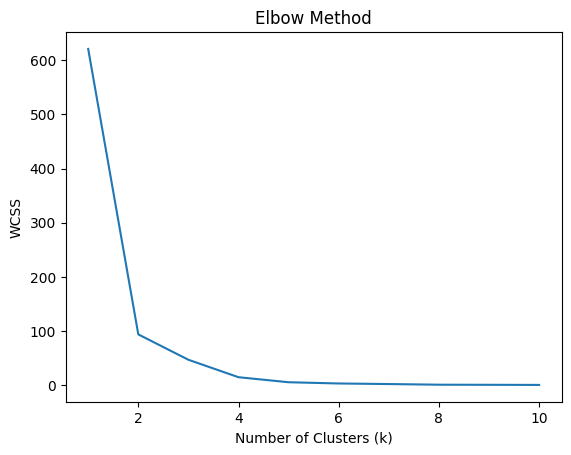

In [20]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title("Elbow Method")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.show()

The optimal k is 4, as the elbow in the plot appears to be at 4. This indicates a significant drop in the WCSS, suggesting that 4 clusters are sufficient to capture the main groupings in the data.

In [21]:
kmeans = KMeans(n_clusters=6, random_state=42)
model=kmeans.fit(X_scaled)
pred=model.predict(X_scaled)
df["Clusters"]=pred

c:\Users\ahmet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning:



KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.




In [22]:
df

,country,ElectricityConsumption2021,ElectricityConsumption2020,ElectricityConsumption2019,Percentile_2021,Percentile_2020,Percentile_2019,LogElectricityConsumption2021,LogElectricityConsumption2020,LogElectricityConsumption2019,Growth_2019_2020,Growth_2020_2021,Growth_2019_2021,Clusters
0,India,1442.75,1328.66,1342.05,5.694466,5.545571,5.611771,7.274306,7.191926,7.201954,-0.997727,8.586847,7.503446,4
1,China,7805.66,7115.08,6802.70,30.808573,29.696973,28.445434,8.962604,8.869972,8.825075,4.592000,9.705864,14.743558,2
2,United States,3979.28,3897.89,3989.38,15.706031,16.269042,16.681560,8.288856,8.268191,8.291391,-2.293339,2.088053,-0.253172,1
3,Indonesia,281.53,266.03,254.67,1.111186,1.110358,1.064901,5.640239,5.583609,5.539969,4.460675,5.826411,10.546982,5
4,Pakistan,132.32,119.39,119.15,0.522261,0.498311,0.498225,4.885223,4.782395,4.780383,0.201427,10.830053,11.053294,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,Cook Islands,0.04,0.04,0.04,0.000158,0.000167,0.000167,-3.218876,-3.218876,-3.218876,0.000000,0.000000,0.000000,0
203,Nauru,0.04,0.03,0.03,0.000158,0.000125,0.000125,-3.218876,-3.506558,-3.506558,0.000000,33.333333,33.333333,0
204,Saint Pierre and Miquelon,0.05,0.05,0.05,0.000197,0.000209,0.000209,-2.995732,-2.995732,-2.995732,0.000000,0.000000,0.000000,0
205,Montserrat,0.01,0.01,0.02,0.000039,0.000042,0.000084,-4.605170,-4.605170,-3.912023,-50.000000,0.000000,-50.000000,0


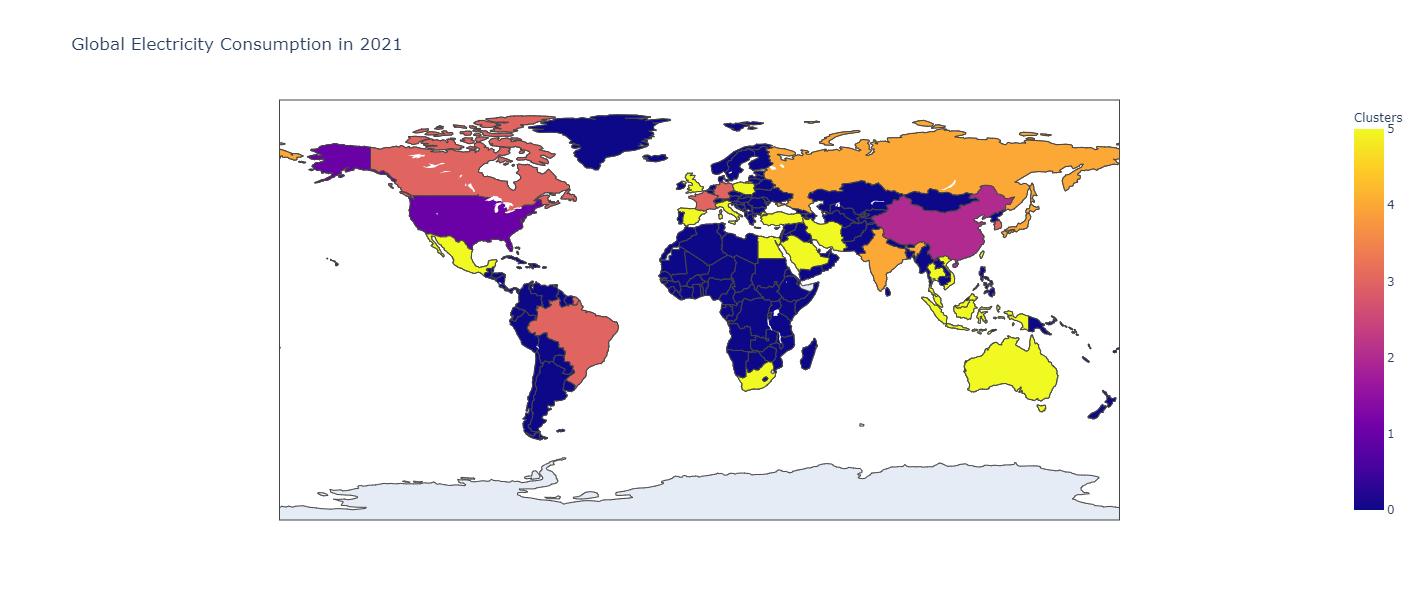

In [23]:
fig = px.choropleth(
    df,
    locations="country",
    locationmode="country names",
    color="Clusters",
    hover_name="country",
    color_continuous_scale="Plasma",
    title="Global Electricity Consumption in 2021"
)


# Update layout for larger size
fig.update_layout(
    width=1000,  # Set the width
    height=600   # Set the height
)

fig.show()

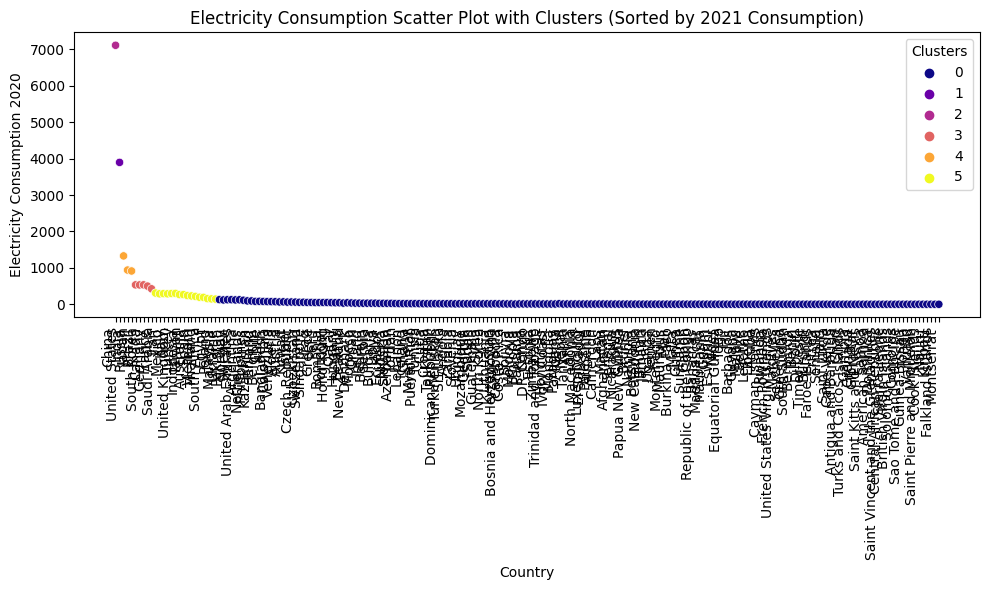

In [24]:
sorted_df = df.sort_values(by="ElectricityConsumption2021", ascending=False)

plt.figure(figsize=[10,6])
sns.scatterplot(data=sorted_df, x="country", y="ElectricityConsumption2020", hue="Clusters", palette="plasma")
plt.xlabel("Country")
plt.ylabel("Electricity Consumption 2020")
plt.title("Electricity Consumption Scatter Plot with Clusters (Sorted by 2021 Consumption)")
plt.xticks(rotation=90, ha="right")  
plt.legend(title="Clusters")
plt.tight_layout()  
plt.show()

# Conclusion

I thoroughly enjoyed working on this data visualization project, especially the part where we could analyze the results. One of the most surprising findings for me was discovering the significant electricity consumption in China. It's truly staggering. This insight made me realize that electricity consumption is closely linked to a country's level of development. 

Looking at the data, it's evident that countries like Liberia and Moldova are experiencing rapid increases in their electricity consumption. As we move forward, it's essential for developed countries to extend a helping hand to regions with minimal electricity consumption. By providing support and resources, we can contribute to their development and progress.

I hope you found this report as enjoyable and enlightening as I did creating it. If you have any questions or would like to discuss further, please feel free to reach out to me!

📧 [**My Email**](mailto:atalhabektas@gmail.com)

🔗 [**My LinkedIn**](https://www.linkedin.com/in/ahmet-talha-bekta%C5%9F-056844216/)

💻 [**My GitHub**](https://github.com/ahmettalhabektas)

👨‍💻 [**My Kaggle**](https://www.kaggle.com/ahmettalhabektas)

📋 [**My Medium**](https://medium.com/@ahmettalhabektas)

Wishing you a fantastic day ahead! :)

